# <font color = 'indianred'>**Identify Duplicate Questions in Quora Question Pairs using BERT** </font>

**Objective:**

The objective of this notebook is to understand the Quora duplicate question answering dataset and tokenization for sentence pair classification task.

**Key Changes and Innovations from prebious Notebook:**

Most of the functions will be same as previous notebooks. We will need to change the tokenizer function. We will also see that the output of the tokenization function will change.

**Plan**

1. Set Environment
2. Load Dataset
3. Accessing and Manipulating Splits
4. Load Pre-trained Tokenizer
5. Create Function for Tokenizer



















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers datasets swifter -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 16.7 MB/s eta 0:00:00


<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard data science librraies for data handling and v isualization
import numpy as np
import pandas as pd

from datasets import load_dataset, ClassLabel, DatasetDict
from transformers import AutoTokenizer
from pprint import pprint

## NEW #######
import swifter  # Enables efficient and speedy apply operations on Pandas dataframes or series
from huggingface_hub import login
from google.colab import userdata
import matplotlib.pyplot as plt



In [3]:
hf_token = userdata.get('HF_TOKEN')

In [4]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


# <font color = 'indianred'> **2. Load Data set**
    


**Quora Dataset**

The Quora dataset is composed of question pairs, and the task is to determine if the questions are paraphrases of each other (have the same meaning).



In [5]:
quora_dataset = load_dataset("quora", trust_remote_code=True)

README.md:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

quora.py:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

<font color = 'indianred'> *Understanding your data*



In [6]:
print(quora_dataset)

DatasetDict({
    train: Dataset({
        features: ['questions', 'is_duplicate'],
        num_rows: 404290
    })
})


<font color = 'indianred'> *Understanding the datatype of columns*


In [7]:
quora_dataset['train'].features


{'questions': Sequence(feature={'id': Value(dtype='int32', id=None), 'text': Value(dtype='string', id=None)}, length=-1, id=None),
 'is_duplicate': Value(dtype='bool', id=None)}

1. *`questions`*: This is a sequence of question pairs. Each item in this sequence is a dictionary with two keys:
   - `id`: An integer representing the unique identifier of the question.
   - `text`: A string representing the text of the question.

2. *`is_duplicate`*: This is a boolean value indicating whether the pair of questions are considered duplicates (True if they are duplicates, False otherwise).



<font color = 'indianred'> *Acess indivdual element* </font>


In [8]:
# get the first example of the dataset
quora_dataset['train'][0]

{'questions': {'id': [1, 2],
  'text': ['What is the step by step guide to invest in share market in india?',
   'What is the step by step guide to invest in share market?']},
 'is_duplicate': False}

To align with the requirements of the Hugging Face `Trainer`, we need to implement two key modifications.
- First, the target variable name should be `labels`, as this is the default expected by the `Trainer`. Therefore, we'll rename `is_duplicate` to `labels`. This renaming ensures the framework correctly identifies the target variable during training and evaluation processes.
- Second, the datatype of the original `is_duplicate` variable is `bool`, but for optimal compatibility and functionality within the Hugging Face ecosystem, categorical target variables should be of type `ClassLabel`. Converting the `labels` to `ClassLabel` not only aligns with the expected input format but also facilitates accurate and efficient processing during model training, evaluation, and metric computation.

In [9]:
# Renaming 'is_duplicate' column to 'labels' to match the naming convention expected by Hugging Face Trainer
quora_dataset = quora_dataset.rename_column('is_duplicate', 'labels')


In [10]:
# Retrieve the features of the 'train' split from the quora_dataset
features = quora_dataset['train'].features

# Define the 'labels' feature as a ClassLabel with two classes: 'not_duplicate' and 'duplicate'
features['labels'] = ClassLabel(num_classes=2, names=['not_duplicate', 'duplicate'])

# Cast the 'labels' column in the dataset to the ClassLabel type, ensuring compatibility with Hugging Face's Trainer
quora_dataset = quora_dataset.cast(features)

Casting the dataset:   0%|          | 0/404290 [00:00<?, ? examples/s]

In [11]:
# check dataset
quora_dataset

DatasetDict({
    train: Dataset({
        features: ['questions', 'labels'],
        num_rows: 404290
    })
})

In [12]:
# Verify the change by printing the updated features of the 'train' split, ensuring 'labels' is now of type ClassLabel
quora_dataset['train'].features

{'questions': Sequence(feature={'id': Value(dtype='int32', id=None), 'text': Value(dtype='string', id=None)}, length=-1, id=None),
 'labels': ClassLabel(names=['not_duplicate', 'duplicate'], id=None)}

<font color = 'indianred'> *Exploratory Data Analysis (EDA)* </font>

Having gained a preliminary understanding of our dataset's structure and content, it's time to dig deeper with Exploratory Data Analysis (EDA). EDA is a crucial step in any data science project, as it allows us to uncover patterns, spot anomalies, and make informed decisions about further steps.

In this section, we will focus on **two key aspects**:

1. The distribution of class labels  
2.Length of reviews





<font color = 'indianred'> *Change dataset format to Pandas*  </font>


In [13]:
# this will convert all the splits into Pandas dataframe
quora_dataset.set_format(type='pandas')


In [14]:
# get all rows from tarining split
df_train = quora_dataset['train'][:]


After setting the format to `'pandas'`, accessing the dataset with dictionary-style indexing (like imdb_dataset['train']) will return the data in the specified format. Here, the [:] is a slicing operation that retrieves all rows from the training split. Since you've set the format to 'pandas', df_train will be a pandas DataFrame containing all the reviews and labels from the training split of the IMDB dataset.

In [15]:
df_train.head()


,questions,labels
0,"{'id': [1, 2], 'text': ['What is the step by s...",0
1,"{'id': [3, 4], 'text': ['What is the story of ...",0
2,"{'id': [5, 6], 'text': ['How can I increase th...",0
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",0
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",0


We need  to unpack the 'questions' column, which contains structured data (likely dictionaries), into separate columns in the `df_train` DataFrame. The 'id' and 'text' keys within each dictionary in the 'questions' column are unpacked and set as separate columns ('id' and 'text') in the `df_train` DataFrame.

In [16]:
df_train[['id', 'text']] = df_train['questions'].swifter.apply(pd.Series)

Pandas Apply:   0%|          | 0/404290 [00:00<?, ?it/s]

- `df_train[['id', 'text']] = df_train['questions'].swifter.apply(pd.Series)`: This line is applying the `pd.Series` function to each element in the 'questions' column of the `df_train` DataFrame. The `apply` function is used to transform each element of the 'questions' column (which itself appears to be a dictionary or a similar structure with keys 'id' and 'text') into a separate Series.


In [17]:
df_train

,questions,labels,id,text
0,"{'id': [1, 2], 'text': ['What is the step by s...",0,"[1, 2]",[What is the step by step guide to invest in s...
1,"{'id': [3, 4], 'text': ['What is the story of ...",0,"[3, 4]",[What is the story of Kohinoor (Koh-i-Noor) Di...
2,"{'id': [5, 6], 'text': ['How can I increase th...",0,"[5, 6]",[How can I increase the speed of my internet c...
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",0,"[7, 8]",[Why am I mentally very lonely? How can I solv...
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",0,"[9, 10]","[Which one dissolve in water quikly sugar, sal..."
...,...,...,...,...
404285,"{'id': [433578, 379845], 'text': ['How many ke...",0,"[433578, 379845]",[How many keywords are there in the Racket pro...
404286,"{'id': [18840, 155606], 'text': ['Do you belie...",1,"[18840, 155606]","[Do you believe there is life after death?, Is..."
404287,"{'id': [537928, 537929], 'text': ['What is one...",0,"[537928, 537929]","[What is one coin?, What's this coin?]"
404288,"{'id': [537930, 537931], 'text': ['What is the...",0,"[537930, 537931]",[What is the approx annual cost of living whil...


In [18]:
df_train_final = df_train.drop('questions', axis=1)


In [19]:
df_train_final

,labels,id,text
0,0,"[1, 2]",[What is the step by step guide to invest in s...
1,0,"[3, 4]",[What is the story of Kohinoor (Koh-i-Noor) Di...
2,0,"[5, 6]",[How can I increase the speed of my internet c...
3,0,"[7, 8]",[Why am I mentally very lonely? How can I solv...
4,0,"[9, 10]","[Which one dissolve in water quikly sugar, sal..."
...,...,...,...
404285,0,"[433578, 379845]",[How many keywords are there in the Racket pro...
404286,1,"[18840, 155606]","[Do you believe there is life after death?, Is..."
404287,0,"[537928, 537929]","[What is one coin?, What's this coin?]"
404288,0,"[537930, 537931]",[What is the approx annual cost of living whil...


In [20]:
df_train_final['text'][0]

array(['What is the step by step guide to invest in share market in india?',
       'What is the step by step guide to invest in share market?'],
      dtype=object)

<font color = 'indianred'> *Visualize distribution of class labels* </font>

<Axes: ylabel='labels'>

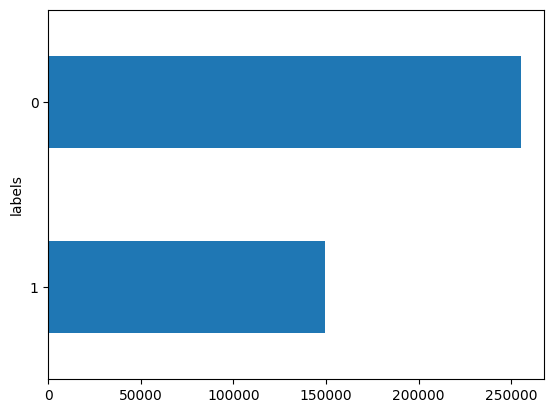

In [21]:
# check distribution of class labels in training dataset
df_train_final['labels'].value_counts(ascending=True).plot.barh()


The dataset appears to be somewhat imbalanced, which is a common issue that can significantly impact the performance of classification models, particularly for the minority class. We might need to account for the imbalance in our loss function.

<font color = 'indianred'> *Check length of the reviews* </font>

In [22]:
df_train_final['words_per_question_pair'] = df_train['text'].apply(lambda x: sum(len(sent.split()) for sent in x))


The code calculates the total number of words for each question pair in the `df_train` DataFrame and stores the result in a new column, `words_per_question_pair`, in the `df_train_final` DataFrame. Specifically, it applies a lambda function to the 'text' column of `df_train`, which iterates through each question pair (`x`), splits each question (`sent`) into words, and sums the word counts to obtain the total number of words per question pair.

In [23]:
df_train_final.head()

,labels,id,text,words_per_question_pair
0,0,"[1, 2]",[What is the step by step guide to invest in s...,26
1,0,"[3, 4]",[What is the story of Kohinoor (Koh-i-Noor) Di...,21
2,0,"[5, 6]",[How can I increase the speed of my internet c...,24
3,0,"[7, 8]",[Why am I mentally very lonely? How can I solv...,20
4,0,"[9, 10]","[Which one dissolve in water quikly sugar, sal...",20


<font color = 'indianred'> *Plot the distribution of review length* </font>

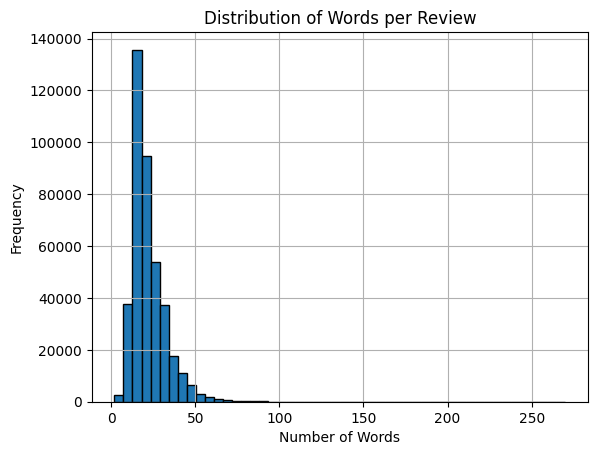

In [24]:
# Plot a histogram of the 'words_per_review' column
df_train_final['words_per_question_pair'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Review')

# Display the plot
plt.show()


In [25]:
# We sill use BERT model for this notebook. The model has a  limit of 512 tokens
# On average, a rough estimate is that 512 tokens might translate to about 400 words
# Let us check how many reviews has more than 400 words

count = (df_train_final['words_per_question_pair'] > 400).sum()
print(f"Number of reviews with more than 400 words: {count}")


Number of reviews with more than 400 words: 0


Since the toytal words in question pairs is less thna 300, we will not need to  implement advanced text handling techniques such as chunking or segmenting longer texts and can directly leverage BERT for the classification task.

<font color = 'indianred'>*Reset dataset format*</font>

After completing the Exploratory Data Analysis (EDA), we will no longer need the Pandas DataFrame. The next step will be tokenization. For this phase, we will use Tokenizer library from Hugging Face. Huggingface Tokenizer integrates seamlessly with Hugging Face datasets.Therefore, we will convert the dataset back to the Hugging Face dataset format.

In [26]:
quora_dataset.reset_format()


In [27]:
quora_dataset


DatasetDict({
    train: Dataset({
        features: ['questions', 'labels'],
        num_rows: 404290
    })
})

# <font color = 'indianred'> **3. Accessing and Manuplating Splits**</font>

We only have train split, we will create train/valid/test splits now.

<font color = 'indianred'>*Create futher subdivions of the splits*</font>

In [28]:
# Split the test set into test and validation sets
train_temp_splits = quora_dataset["train"].train_test_split(
    test_size=0.7, seed=42)  # 70% for training, 30% for test/validation

val_test_splits = train_temp_splits["test"].train_test_split(
    test_size=0.5, seed=42)  # 15% for validation and 15% for test

# Extract the test and validation splits
train_split = train_temp_splits["train"]
valid_split = val_test_splits["train"]
test_split = val_test_splits["test"]


<font color = 'indianred'> *Create subset for experimentation* </font>

In [29]:
train_split_small = train_split.shuffle(seed=32).select(range(15000))
val_split_small = valid_split.shuffle(seed=32).select(range(2000))
test_split_small = test_split.shuffle(seed=32).select(range(2000))


<font color = 'indianred'>*Combine splits*</font>

We will combine train and validation splits as we will be applying the same processing steps to both the splits.


In [30]:
train_val_small = DatasetDict(
    {"train": train_split_small, "valid": val_split_small})

In [31]:
train_val_small

DatasetDict({
    train: Dataset({
        features: ['questions', 'labels'],
        num_rows: 15000
    })
    valid: Dataset({
        features: ['questions', 'labels'],
        num_rows: 2000
    })
})

We have created the datset. The next step is to tokenize the dataset in a format so that we can pass the tokenized inputs to the pre-trained model.

# <font color = 'indianred'>**4. Load pre-trained Tokenizer**</font>

In our next step, we will download a pre-trained tokenizer specifically designed to work with BERT. This tokenizer will handle the conversion of our text into a format that BERT can understand.

<img src ="https://drive.google.com/uc?export=view&id=1tC0hHTW_dd6PYVkl5NvPZ3wnhcue-QKr" width =800>



In [32]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

- `checkpoint = "bert-base-uncased"` specifies the pre-trained model we want to use. BERT has various versions, and "bert-base-uncased" refers to the base version trained on uncased English text.

-  `tokenizer = AutoTokenizer.from_pretrained(checkpoint)` downloads and initializes the tokenizer for the specified checkpoint. This method takes care of downloading the required files and setting up the tokenizer with the correct configurations.




<font color = 'indianred'>*Understanding pre-trained Tokenizer*

We will now understand how the tokenizer work by feeding one question pair.

In [33]:
text = train_val_small['train'][0]['questions']['text']
text


['How can I recover my email address if I forgot my recovery phone number and email address?',
 'How will I recover my Gmail if I forgot my password and I lost my phone recovery?']

In [34]:
# tokenizer??

In [35]:
encoded_text = tokenizer(
    text[0], text[1], padding=True, truncation=True, return_tensors='pt')

In [36]:
encoded_text


{'input_ids': tensor([[  101,  2129,  2064,  1045,  8980,  2026, 10373,  4769,  2065,  1045,
          9471,  2026,  7233,  3042,  2193,  1998, 10373,  4769,  1029,   102,
          2129,  2097,  1045,  8980,  2026, 20917,  4014,  2065,  1045,  9471,
          2026, 20786,  1998,  1045,  2439,  2026,  3042,  7233,  1029,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Difference from one sequence case

1. **`input_ids`:**
   - <font color = 'indianred'>In the case of two sequences, the special token `[SEP]` (with token ID `102`) is used to separate the two sequences. This token acts as a delimiter, indicating to the model where one sequence ends and the next begins.</font>

2. **`token_type_ids`:**
   - <font color = 'indianred'>In this tensor, one sequence is marked with `0`s, and the other sequence is marked with `1`s. The model uses this information to understand the sequence boundaries.</font>

3. **`attention_mask`:**
   - This tensor remains similar to the single sequence case. It indicates to the model which tokens should be considered (marked with `1`) and which tokens are padding and should be ignored (marked with `0`, not present in this particular example).




In [37]:
tokens_first_sentence = tokenizer.convert_ids_to_tokens(encoded_text.input_ids[0])

pprint(tokens_first_sentence, width = 80, compact = True)



['[CLS]', 'how', 'can', 'i', 'recover', 'my', 'email', 'address', 'if', 'i',
 'forgot', 'my', 'recovery', 'phone', 'number', 'and', 'email', 'address', '?',
 '[SEP]', 'how', 'will', 'i', 'recover', 'my', 'gma', '##il', 'if', 'i',
 'forgot', 'my', 'password', 'and', 'i', 'lost', 'my', 'phone', 'recovery', '?',
 '[SEP]']


In this sequence, the notable difference lies in the presence of an additional [SEP] token, which is used to demarcate the boundaries between two distinct sentences or questions within a single input to BERT. While a single [SEP] token is typically used to mark the end of a sequence in tasks involving only one sentence or question, the presence of a second [SEP] token here indicates that the input comprises two separate sequences. This structural cue is crucial for BERT to correctly interpret and process each sequence within the context of sentence pair tasks, ensuring that the model recognizes where one sequence ends and the next begins.






#<font color = 'indianred'> **5. Create function for Tokenizer**



In [38]:
def tokenize_fn(batch):
  question1 = []
  question2 = []
  for question_pair in batch['questions']:
    question1.append(question_pair['text'][0])
    question2.append(question_pair['text'][1])

  return tokenizer(text = question1, text_pair = question2, truncation=True)


-  `tokenize_fn` function takes a different approach (compared to previous notebook) by explicitly handling pairs of sentences. It separates and accumulates the individual sentences from each pair into two lists, `question1` and `question2`. It then passes these lists to the tokenizer with the `text` and `text_pair` parameters, enabling the tokenizer to process and understand the input as paired sequences. This approach is essential for tasks involving the relationship between sentence pairs, as it ensures the model receives and processes the input sentences in the context of their respective pairs.

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [39]:
tokenized_dataset_small = train_val_small.map(tokenize_fn, batched=True)

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [40]:
tokenized_dataset_small


DatasetDict({
    train: Dataset({
        features: ['questions', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15000
    })
    valid: Dataset({
        features: ['questions', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

We can see that tokenization step has added three new columns `('input_ids', 'token_type_ids', 'attention_mask')` to the dataset.

We no longer need the column `questions`, hence we ill remove it. Further, we will set the dataset format to 'torch' ensuring that the tokenized dataset is converted into PyTorch tensors, making it directly compatible with PyTorch models and training routines.

In [41]:
tokenized_dataset_small = tokenized_dataset_small.remove_columns(
    ['questions']
)

In [42]:
tokenized_dataset_small.set_format(type='torch')

In [43]:
tokenized_dataset_small

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 15000
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [44]:
tokenized_dataset_small['train'].features

{'labels': ClassLabel(names=['not_duplicate', 'duplicate'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [45]:
print(len(tokenized_dataset_small["train"]["input_ids"][2]))
print(len(tokenized_dataset_small["train"]["input_ids"][1]))

21
32


The varying lengths in the dataset indicate that padding has not been applied yet. Instead of padding the entire dataset, we prefer processing small batches during training. Padding is done selectively for each batch based on the maximum length in the batch. We will discuss this in more detail in a later section of this notebook.